## 📌 Smart Home Energy Efficiency Dataset

This dataset comes from a **smart neighborhood** where **650 homes** are monitored using various sensors to track **energy usage**, **temperature**, **humidity**, and **appliance usage**.

### 🎯 Project Goal
The main goal of this project is to **predict the energy efficiency** of each home, where:
- `1` → Energy-efficient home  
- `0` → Energy-inefficient home  

---

### 📊 Dataset Overview
The dataset contains **7 columns**, described below:

| # | Feature Name | Description |
|:-:|---------------|--------------|
| 1️⃣ | `temperature_avg` | Average indoor temperature of the home (°C) |
| 2️⃣ | `humidity_avg` | Average indoor humidity of the home (%) |
| 3️⃣ | `light_usage` | Daily usage of lighting (hours) |
| 4️⃣ | `ac_usage` | Daily usage of heating/cooling systems (hours) |
| 5️⃣ | `num_residents` | Number of residents in the home |
| 6️⃣ | `device_efficiency` | Average efficiency of electrical appliances (0 → 1) |
| 7️⃣ | `efficient_home` | **Target variable**, indicates whether the home is energy-efficient (`0 = inefficient`, `1 = efficient`) |

---

This section serves as an **introduction** to understand the dataset and prepare for the next steps in **data analysis** and **model building**.

In [30]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , StratifiedKFold , cross_val_score , RandomizedSearchCV , KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report

In [31]:
# Reading data from a CSV file and displaying all information
data = pd.read_csv('smart_home_efficiency.csv')
pd.set_option('display.width',1000)
print(data.head(5).round(2),'\n')            # Display the first 5 rows of the dataset
print(data.shape,'\n')                       # Display the number of rows and columns in the dataset
print(data.describe().round(2),'\n')         # Show a statistical summary of all numerical columns (count, mean, std, min, max, etc.)
print(data.groupby('efficient_home').size()) # Group the dataset by 'efficient_home' and calculate the mean of each feature to see differences between efficient and inefficient homes

   temperature_avg  humidity_avg  light_usage  ac_usage  num_residents  device_efficiency  efficient_home
0            27.48         82.73         6.00      0.57              4               0.66               1
1            24.31         71.90        10.98      8.15              5               0.90               0
2            28.24         50.97         7.48      2.74              3               0.47               1
3            32.62         38.40         5.73      3.37              2               0.84               0
4            23.83         90.00         9.61      3.51              5               0.72               0 

(650, 7) 

       temperature_avg  humidity_avg  light_usage  ac_usage  num_residents  device_efficiency  efficient_home
count           650.00        650.00       650.00    650.00         650.00             650.00           650.0
mean             24.93         56.32         8.16      5.04           3.59               0.69             0.5
std               4.7

## 📊 Exploratory Data Visualization

In this section, we focus on **visualizing the dataset** to better understand the data distribution, relationships between features, and potential correlations.

### 🔹 Visualization Goals
1. **Histogram plots** — to explore the overall distribution of each numerical feature and identify potential skewness or outliers.  
2. **Density plots** — to visualize the smooth distribution curves of continuous variables for comparison across features.  
3. **Heatmap** — to observe correlations between numerical variables and detect multicollinearity or strong relationships.

These visualizations help us:
- Understand feature behavior before modeling  
- Detect imbalanced patterns or anomalies  
- Guide future data preprocessing decisions  

Let's dive into the plots 👇

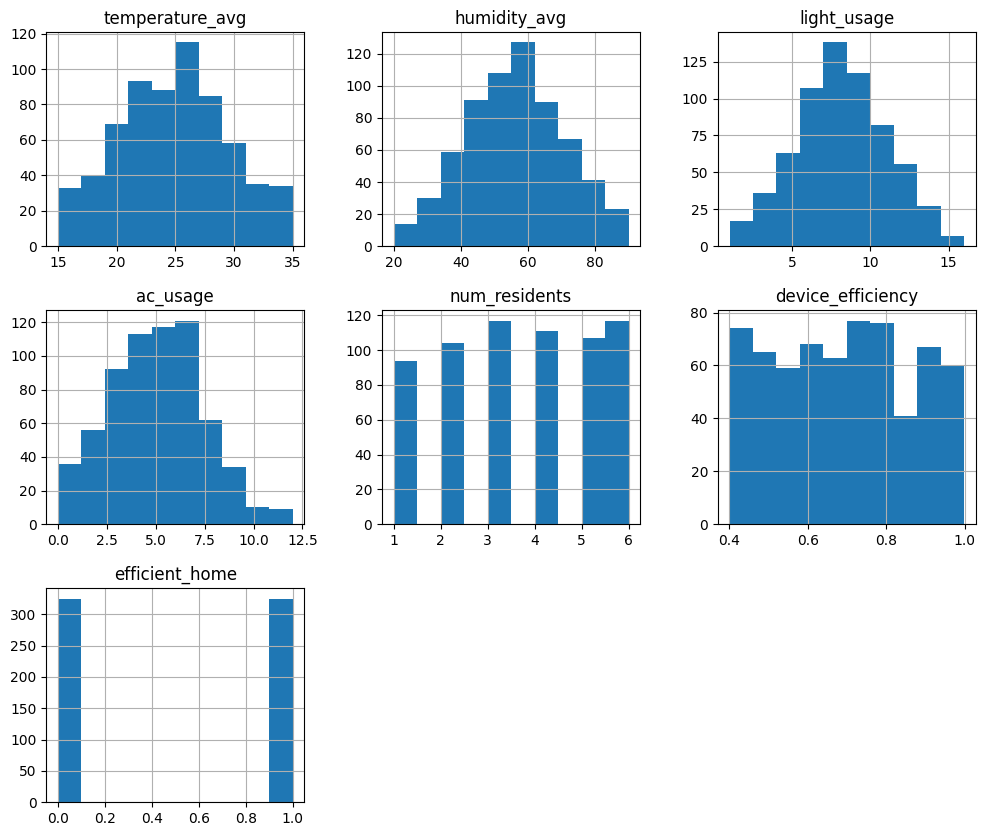

In [32]:
data.hist(sharex=False,sharey=False,xlabelsize=10,ylabelsize=10,figsize=(12,10))
plt.show()

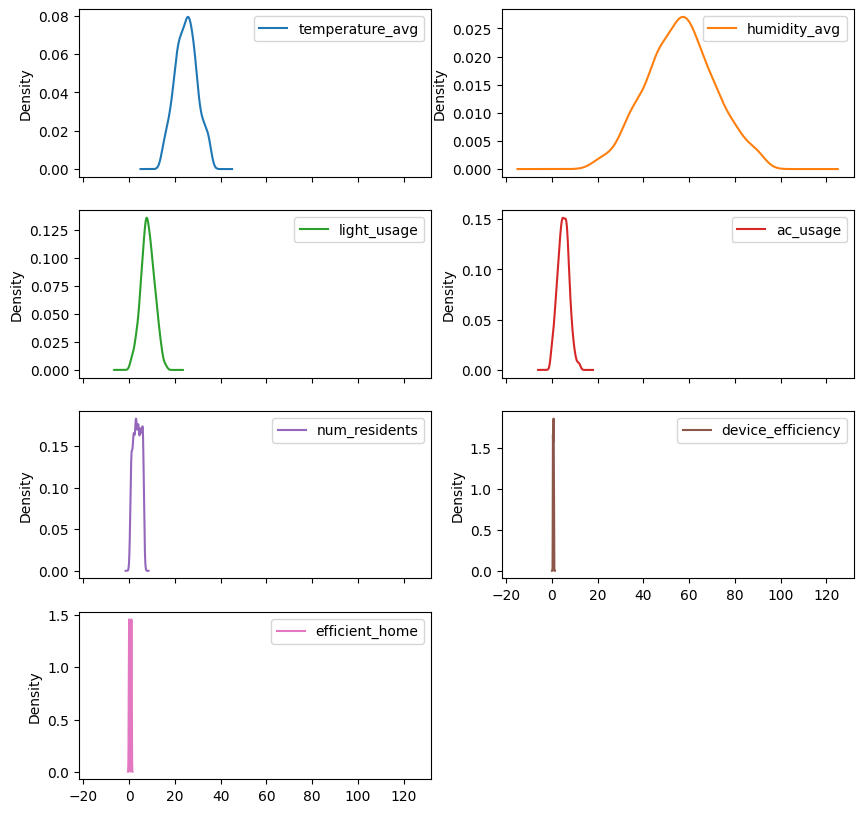

In [33]:
data.plot(kind='density',subplots=True,layout=(4,2),figsize=(10,10))
plt.show()

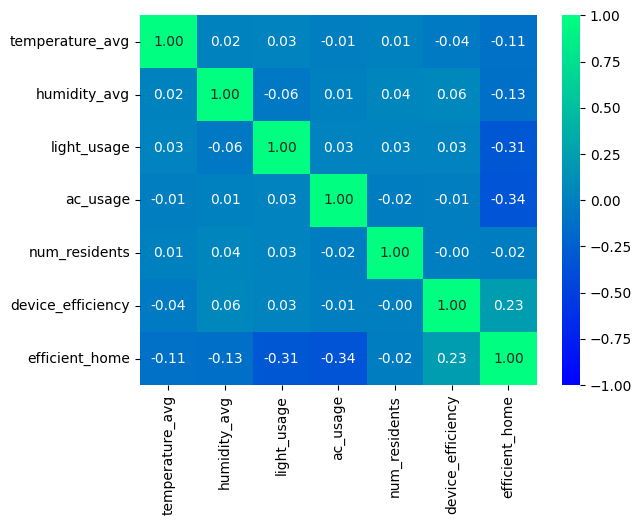

In [34]:
sns.heatmap(data.corr(),vmin=-1,vmax=1,cmap='winter',annot=True,fmt='.2f',cbar=True)
plt.show()

## 🔀 Train-Test Split

Before training our models, we need to **split the dataset** into training and testing sets.  
This step ensures that the model is evaluated on **unseen data**, providing a realistic measure of performance and avoiding overfitting.

Typically:
- The **training set** (e.g., 70–80%) is used to train the model.
- The **testing set** (e.g., 20–30%) is reserved for final performance evaluation.

We'll use `train_test_split` from **scikit-learn** to separate our features (`X`) and target (`y`) into training and testing subsets.

## ⚙️ Spot Check — Baseline Model Evaluation

In this section, we perform a **spot check** to quickly compare multiple baseline algorithms.  
This helps us identify which models perform reasonably well on our dataset before moving on to advanced techniques.

We'll evaluate several classifiers using **cross-validation** and measure their **accuracy** scores.

Key goals:
- Establish initial performance benchmarks  
- Identify underperforming models early  
- Select the most promising candidates for further tuning or pipeline optimization

In [35]:
X = data.drop('efficient_home',axis=1)
Y = data['efficient_home']
x_train , x_test , y_train , y_test = train_test_split(X,Y,test_size=0.22,random_state=7)

In [36]:
models = []
models.append(('LR',LogisticRegression(max_iter=1000)))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('NB',GaussianNB()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('SVM',SVC()))

Name : LR , Accuracy : 72.20 % , STD : 4.45
Name : LDA , Accuracy : 71.80 % , STD : 4.11
Name : KNN , Accuracy : 81.88 % , STD : 5.61
Name : NB , Accuracy : 88.77 % , STD : 4.09
Name : CART , Accuracy : 79.10 % , STD : 2.73
Name : SVM , Accuracy : 76.94 % , STD : 5.81


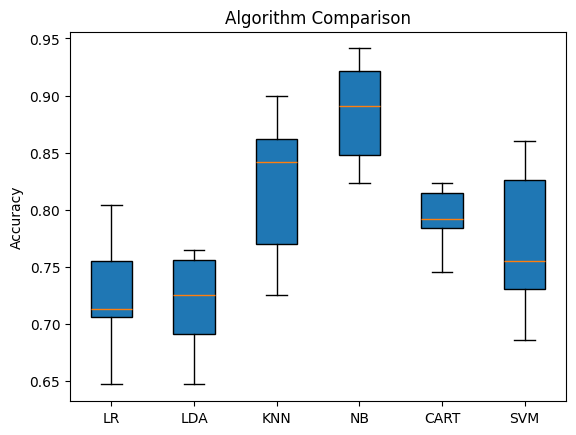

In [37]:
result = []
names = []
for name , model in models:
    kfold = KFold(n_splits=10,shuffle=True,random_state=7)
    cv_result = cross_val_score(model,x_train,y_train,cv=kfold)
    result.append(cv_result)
    names.append(name)
    print(f'Name : {name} , Accuracy : {cv_result.mean()*100:.2f} % , STD : {cv_result.std()*100:.2f}')
plt.figure()
plt.boxplot(result,vert=True,patch_artist=True)
plt.title('Algorithm Comparison')
plt.xticks(ticks=range(1,len(names)+1),labels=names)
plt.ylabel('Accuracy')
plt.show()

## ⚙️ Using Pipelines to Improve Model Performance and Workflow Efficiency

Pipelines allow us to combine multiple steps such as **data preprocessing** (e.g., standardization) and **model training** into a single, unified workflow.  
This approach ensures that:

1. 🔄 All transformations (like scaling) are consistently applied during both **training** and **testing** phases.  
2. 🧠 **Data leakage** is prevented since standardization occurs only within the training folds.  
3. 🧩 The code becomes **cleaner**, easier to maintain, and fully compatible with **hyperparameter tuning** methods such as `GridSearchCV` or `RandomizedSearchCV`.

By including a `StandardScaler` inside the pipeline, we aim to improve model **accuracy**, **consistency**, and **stability** across different machine learning algorithms.

In [38]:
pipline = []
pipline.append(('ScaledLR',Pipeline([('Scaled',StandardScaler()),('LR',LogisticRegression(max_iter=1000))])))
pipline.append(('ScaledLDA',Pipeline([('Scaled',StandardScaler()),('LDA',LinearDiscriminantAnalysis())])))
pipline.append(('ScaledKNN',Pipeline([('Scaled',StandardScaler()),('KNN',KNeighborsClassifier())])))
pipline.append(('ScaledNB',Pipeline([('Scaled',StandardScaler()),('NB',GaussianNB())])))
pipline.append(('ScaledCART',Pipeline([('Scaled',StandardScaler()),('CART',DecisionTreeClassifier())])))
pipline.append(('ScaledSVM',Pipeline([('Scaled',StandardScaler()),('SVM',SVC())])))

In [39]:
# Iterate through each pipeline (StandardScaler + Model), unpack its name and object, and evaluate performance
result = []
names = []
for name , model in pipline:
    kfold = KFold(n_splits=10,shuffle=True,random_state=7)
    cv_result = cross_val_score(model,x_train,y_train,cv=kfold)
    result.append(cv_result)
    names.append(name)
    print(f'Name = {name} , Accuracy : {cv_result.mean()*100:.2f} % , STD : {cv_result.std()*100:.2f}')

Name = ScaledLR , Accuracy : 71.60 % , STD : 4.88
Name = ScaledLDA , Accuracy : 71.80 % , STD : 4.11
Name = ScaledKNN , Accuracy : 84.83 % , STD : 3.99
Name = ScaledNB , Accuracy : 88.77 % , STD : 4.09
Name = ScaledCART , Accuracy : 80.28 % , STD : 3.36
Name = ScaledSVM , Accuracy : 89.37 % , STD : 4.01


In [40]:
# Pipelines
pipe_knn = Pipeline([('Scaled',StandardScaler()),('knn',KNeighborsClassifier())])
pipe_svm = Pipeline([('Scaled',StandardScaler()),('svm',SVC(probability=True))])

# Stratified CV
cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=7)

# KNN: grid
knn_param_grid = {
    'knn__n_neighbors':list(range(1,31,2)),
    'knn__weights':['uniform','distance'],
    'knn__p':[1,2]
}
# SVM: grid
svm_param_grid = {
    'svm__kernel':['rbf','poly','linear'],
    'svm__C':[0.01,0.1,1,10,100],
    # for rbf and poly gamma matters; allow 'scale' and some values
    'svm__gamma':['scale','auto',0.001,0.01,0.1,1],
    'svm__degree':[2,3]
}

In [41]:
# Randomized search for SVC (fast initial search)
svc_random = RandomizedSearchCV(
    estimator=pipe_svm,
    param_distributions=svm_param_grid,
    n_iter=20,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv,
    random_state=7
)
svc_random.fit(x_train,y_train)
print(f'Best SVC (random) {svc_random.best_params_} , {svc_random.best_score_*100:.2f} %')

Best SVC (random) {'svm__kernel': 'rbf', 'svm__gamma': 0.1, 'svm__degree': 3, 'svm__C': 10} , 90.93 %


In [42]:
# Randomized SearchCV for K-Nearest Neighbors (KNN)
knn_random = RandomizedSearchCV(
    estimator=pipe_knn,
    param_distributions=knn_param_grid,
    n_iter=20,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv,
    random_state=7
)
knn_random.fit(x_train,y_train)
print(f'Best KNN (random) {knn_random.best_params_} , {knn_random.best_score_*100:.2f} %')

Best KNN (random) {'knn__weights': 'distance', 'knn__p': 2, 'knn__n_neighbors': 17} , 84.02 %


## 📊 Model Comparison and Final Selection

In this stage, we compared two of the most promising machine learning models:

- 🧠 **Support Vector Machine (SVM)**
- 👥 **K-Nearest Neighbors (KNN)**

After performing **hyperparameter optimization** using `RandomizedSearchCV`, the results were as follows:

- **SVM** achieved the highest accuracy of approximately **90.9%**.  
- **KNN** followed with an accuracy of around **84.0%**.

✅ Based on these results, we select **SVM** as the **final model** for our binary classification task.  
In the next step, the optimized SVM model will be trained on the **entire training dataset** and evaluated on the **test set** to assess its real-world performance.

In [43]:
# Final Model Training and Evaluation
final_svm = pipe_svm.set_params(
    svm__kernel = 'rbf',
    svm__gamma = 0.1,
    svm__C = 10
)
final_knn = pipe_knn.set_params(
    knn__weights = 'distance',
    knn__p = 2,
    knn__n_neighbors = 17
)
# ------------------------
# Fit models on training data
final_svm.fit(x_train,y_train)
final_knn.fit(x_train,y_train)
# ------------------------
# Predict on test data
y_pred_svm = final_svm.predict(x_test)
y_pred_knn = final_knn.predict(x_test)
# -------------------------
# Evaluate performance
print('=== SVM performance ===')
print(f'Accuracy = {accuracy_score(y_test,y_pred_svm)*100:.2f} %')
print(confusion_matrix(y_test,y_pred_svm))
print(classification_report(y_test,y_pred_svm))

print('=== KNN performance ===')
print(f'Accuracy = {accuracy_score(y_test,y_pred_knn)*100:.2f} %')
print(confusion_matrix(y_test,y_pred_knn))
print(classification_report(y_test,y_pred_knn))

=== SVM performance ===
Accuracy = 92.31 %
[[64  7]
 [ 4 68]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        71
           1       0.91      0.94      0.93        72

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143

=== KNN performance ===
Accuracy = 81.82 %
[[48 23]
 [ 3 69]]
              precision    recall  f1-score   support

           0       0.94      0.68      0.79        71
           1       0.75      0.96      0.84        72

    accuracy                           0.82       143
   macro avg       0.85      0.82      0.81       143
weighted avg       0.84      0.82      0.81       143



## 📌 Final Model Selection

In this project, we evaluated two powerful classification algorithms:

- 🧠 **Support Vector Machine (SVM)**
- 👥 **K-Nearest Neighbors (KNN)**

After performing **hyperparameter optimization** and evaluating both models on the **test dataset**, the results were:

- **SVM** achieved higher accuracy of approximately **92.3%**, showing balanced performance across both classes.  
- **KNN** achieved lower accuracy of around **81.8%** and struggled particularly with class **0**.

✅ Based on these findings, **SVM** is selected as the **final model** for deployment or further analysis.  
This ensures more **reliable and consistent predictions** when applied to unseen data.